## 歌词中汉字使用频率分析

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from scipy import stats
import warnings
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
        
warnings.filterwarnings('ignore')

# 设置字体路径
font_path = "/usr/share/fonts/winfonts/simhei.ttf"  
font = FontProperties(fname=font_path)

In [37]:
songs_information = pd.read_csv('/home/python_crawler/music_website/data/song_information_new.csv')
lyrics = songs_information['lyric'].dropna()

In [38]:
# 中文字符的正则表达式
chinese_pattern = re.compile(r'[\u4e00-\u9fff]')

# 提取中文字符
all_chinese_text = ""
for lyric in lyrics:       
    chinese_chars = chinese_pattern.findall(str(lyric))
    all_chinese_text += ''.join(chinese_chars)
chinese_chars = list(all_chinese_text)

In [39]:
# 统计字符出现次数
char_counter = Counter(chinese_chars)
char_counts = pd.DataFrame(
    list(char_counter.items()), 
    columns=['Character', 'Counts']
    ).sort_values('Counts', ascending=False)
        

total_chars = sum(char_counter.values())
char_counts['Frequency'] = char_counts['Counts'] / total_chars
        
print(f"共有 {len(char_counts)} 个不同的汉字")
print(f"总字符数: {total_chars}")

top_n = 20
print(f"\n出现频率最高的 {top_n} 个汉字:")
print(char_counts.head(top_n).to_string(index=False))

共有 5777 个不同的汉字
总字符数: 3147333

出现频率最高的 20 个汉字:
Character  Counts  Frequency
        的  116370   0.036974
        我  107021   0.034004
        你   84455   0.026834
        不   65239   0.020728
        一   50468   0.016035
        是   41840   0.013294
        在   35921   0.011413
        有   32614   0.010362
        了   27322   0.008681
        爱   24862   0.007899
        人   23234   0.007382
        想   20816   0.006614
        心   20383   0.006476
        着   19323   0.006139
        天   18985   0.006032
        要   18321   0.005821
        过   17958   0.005706
        会   17538   0.005572
        就   17481   0.005554
        来   17251   0.005481


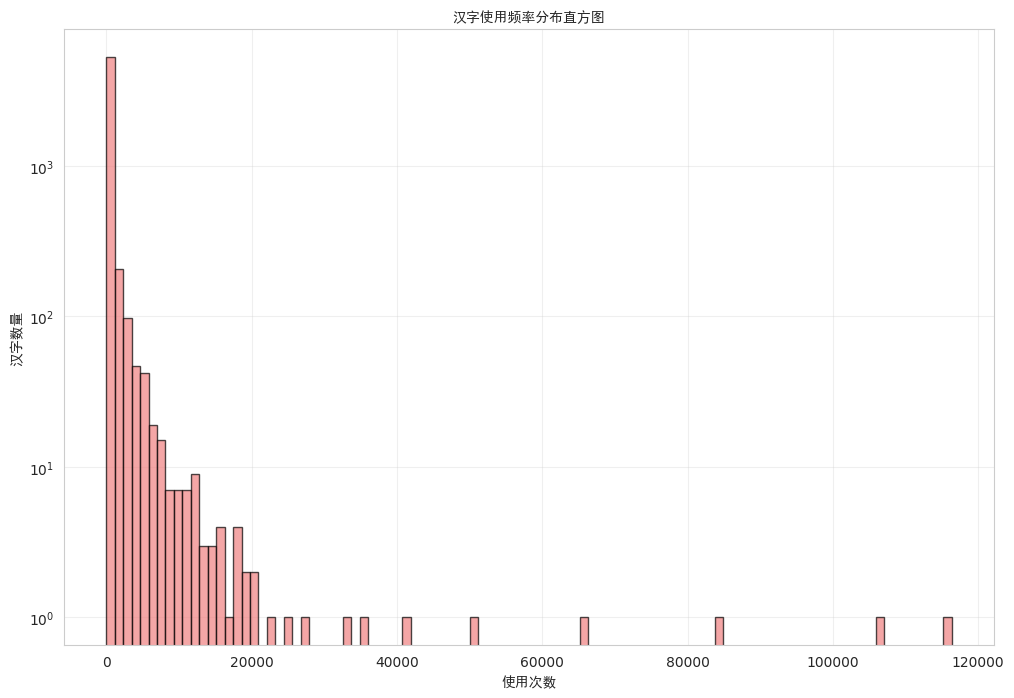

In [40]:
"""绘制字符出现次数分布直方图""" 
plt.figure(figsize=(12, 8))
bins = 100

# 绘制直方图
counts = char_counts['Counts']
# plt.subplot(2, 2, 1)
# plt.hist(counts, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
# plt.xlabel('Times')
# plt.ylabel('Character Number')
# plt.title('汉字出现次数分布直方图')
# plt.grid(True, alpha=0.3)
        
# 对数坐标直方图
# plt.subplot(2, 2, 2)
plt.hist(counts, bins=bins, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('使用次数', fontproperties=font)
plt.ylabel('汉字数量', fontproperties=font)
plt.title('汉字使用频率分布直方图', fontproperties=font)
plt.yscale('log')
plt.grid(True, alpha=0.3)


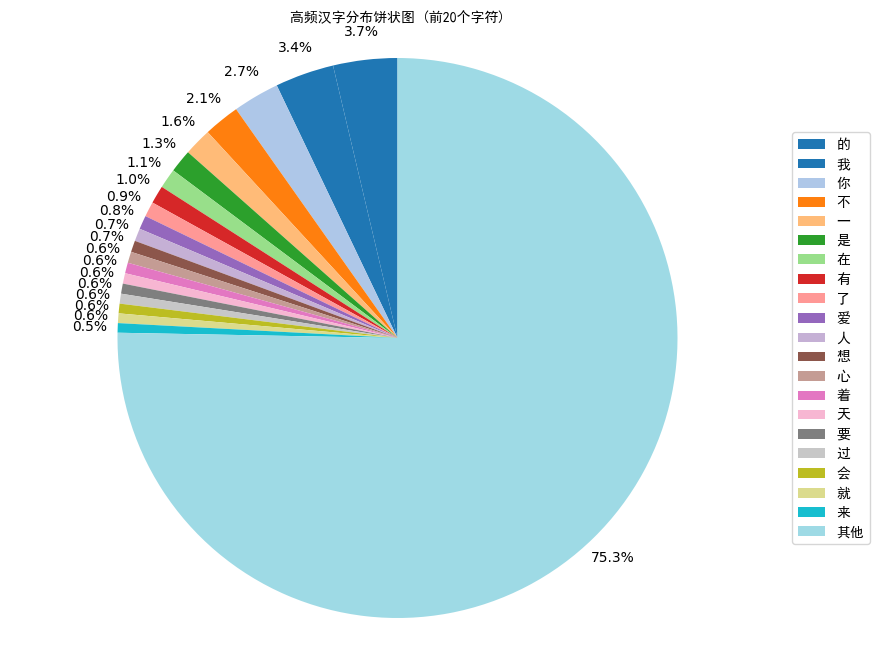

In [53]:
# 高频汉字分布饼状图
plt.figure(figsize=(10, 8))

top_n = 20
top_chars = char_counts.head(top_n)
others_count = char_counts.iloc[top_n:]['Counts'].sum()
        
# 准备数据
labels = top_chars['Character'].tolist() + ['其他']
sizes = top_chars['Counts'].tolist() + [others_count]
        
# 生成颜色
colors = plt.cm.tab20(np.linspace(0, 0.95, len(labels)))
        
# 创建带连线的标签
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%'
    return my_autopct
    
wedges, texts, autotexts = plt.pie(sizes, autopct=make_autopct(sizes), 
                                      colors=colors, startangle=90,
                                      pctdistance=1.1)

# 添加带连线的标签
plt.legend(wedges, labels, loc="center left", 
              bbox_to_anchor=(1, 0, 0.5, 1), prop=font)
plt.title(f'高频汉字分布饼状图 (前{top_n}个字符)', fontproperties=font)
plt.axis('equal')
plt.show()

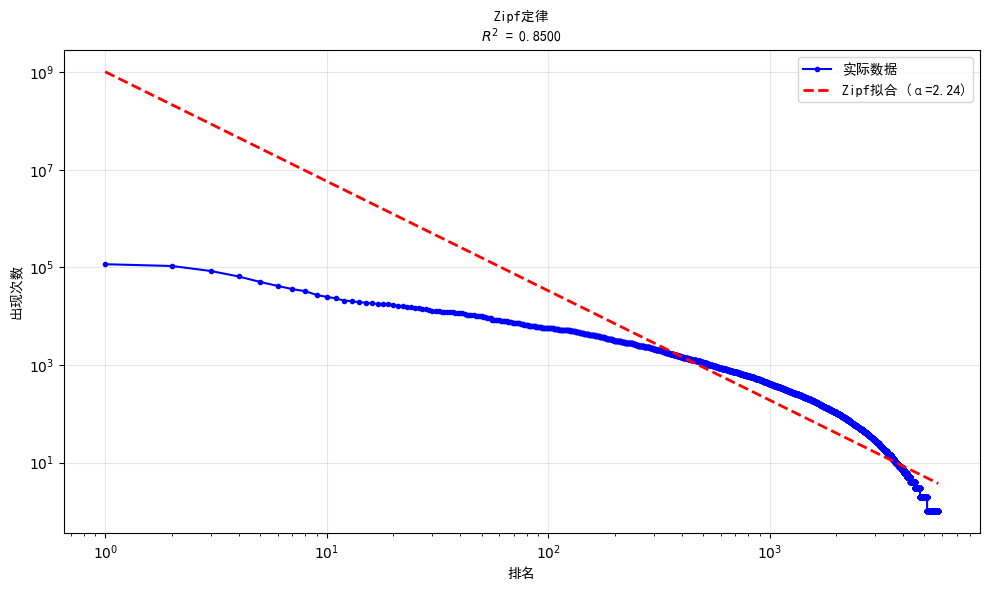

In [71]:
counts = char_counts['Counts'].values
results = []         
# 绘制Zipf定律验证
plt.figure(figsize=(10, 6))
sorted_counts = np.sort(counts)[::-1]
ranks = np.arange(1, len(sorted_counts) + 1)
        
plt.loglog(ranks, sorted_counts, 'bo-', markersize=3, label='实际数据')
        
# 拟合Zipf定律 (power law)
log_ranks = np.log(ranks)
log_counts = np.log(sorted_counts)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_counts)
        
fitted_counts = np.exp(intercept) * ranks ** slope
plt.loglog(ranks, fitted_counts, 'r--', linewidth=2, 
                          label=f'Zipf拟合 (α={-slope:.2f})')
        
plt.xlabel('排名', fontproperties=font)
plt.ylabel('出现次数', fontproperties=font)
plt.title(f'Zipf定律\n$R^2$ = {r_value**2:.4f}', fontproperties=font)
plt.legend(prop=font)
plt.grid(True, alpha=0.3)
        
plt.tight_layout()
plt.show()

## 热评中的关键词分析

In [41]:
import pandas as pd
import jieba
import jieba.analyse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
from stopwords import get_stopwords

In [42]:
comments_information = pd.read_csv('/home/python_crawler/data/comments_information_new.csv')
comments = comments_information['comment'].dropna()

In [49]:
# 加载停用词
stopwords = set()
chinese_stopwords = set(get_stopwords('chinese'))
# 加载哈工大停用词表（https://raw.githubusercontent.com/goto456/stopwords/master/hit_stopwords.txt）
with open('/home/python_crawler/hit_stopwords.txt', 'r', encoding='utf-8') as f:
    hit_stopwords = set(line.strip() for line in f if line.strip())
stopwords.update(hit_stopwords)

basic_stopwords = {
        # 代词
        '我', '你', '他', '她', '它', '我们', '你们', '他们', '她们', '它们',
        '这', '那', '这个', '那个', '这些', '那些', '这里', '那里',
        '自己', '别人', '大家', '咱们',
        
        # 介词连词
        '的', '了', '在', '是', '和', '与', '及', '以及', '或者', '但是',
        '因为', '所以', '如果', '那么', '然后', '接着', '于是', '而且',
        '不过', '可是', '然而', '因此', '由于', '关于', '对于', '根据',
        
        # 副词
        '很', '非常', '十分', '特别', '尤其', '更加', '比较', '相当',
        '还是', '就是', '只是', '仅仅', '已经', '正在', '将要', '可能',
        
        # 量词
        '一', '二', '三', '四', '五', '六', '七', '八', '九', '十',
        '个', '只', '条', '张', '片', '块', '颗', '粒', '滴', '点', '首歌',
        
        # 动词
        '有', '没有', '是', '不是', '能', '会', '要', '想', '看', '听',
        '说', '讲', '做', '搞', '弄', '给', '让', '使', '把', '被',
        
        # 感叹词语气词
        '啊', '呀', '哦', '嗯', '哈', '嘿', '哼', '哟', '呢', '吧',
        '吗', '呗', '啦', '哪', '什么', '怎么', '为什么', '多少',
        
        # 网络用语和标点
        '哈哈', '呵呵', '嘿嘿', '嘻嘻', '额', '咦', '哇', '喔',
        '真的', '假的', '好的', '不好', '可以', '不可以', '行', '不行',
        
        # 时间词
        '今天', '昨天', '明天', '现在', '以前', '以后', '当时', '这时',
        '那时', '平时', '有时', '总是', '从来', '一直', '刚才', '马上'
    }
stopwords.update(basic_stopwords)

In [50]:
all_words = []
    
# 处理每行文本
for text in comments:
    # 预处理：只保留中文
    chinese_text = ''.join(chinese_pattern.findall(str(text)))
      
    if chinese_text:
        # jieba分词并过滤请用词和单字
        words = jieba.cut(chinese_text)
        filtered_words = [
            word for word in words 
            if len(word) > 1 and word not in stopwords
            ]
            
        all_words.extend(filtered_words)

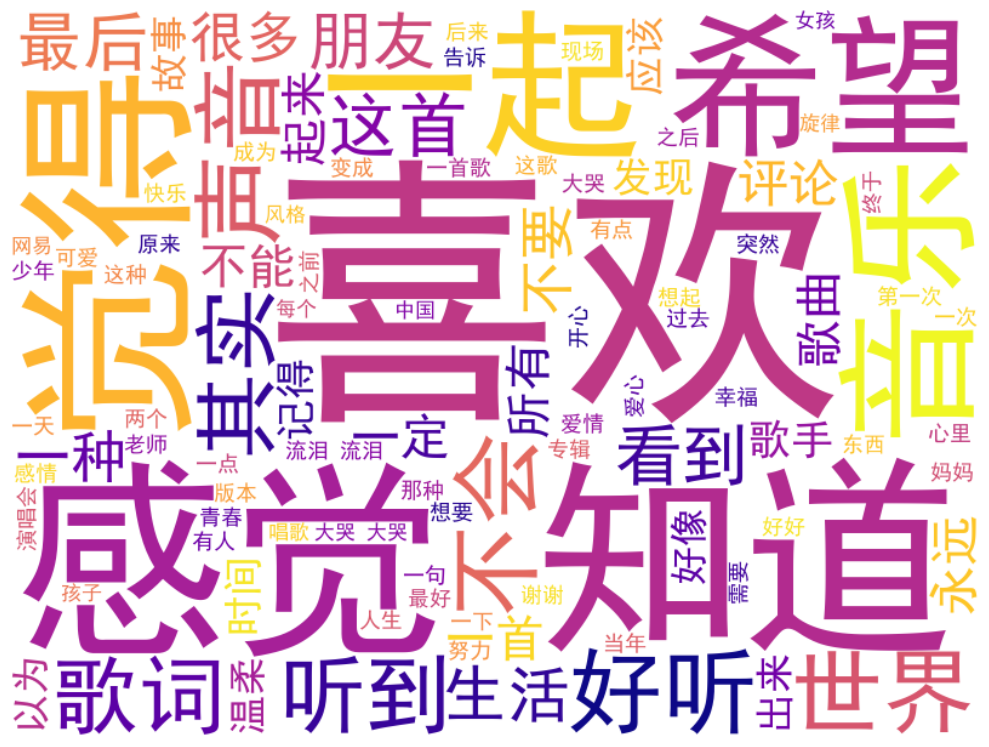

In [51]:
# 绘制词云图
text = ' '.join(all_words)     
wordcloud = WordCloud(
        font_path='simhei.ttf',  
        width=800,
        height=600,
        background_color='white',
        max_words=100,
        relative_scaling=0.5,
        colormap='plasma',
        stopwords=stopwords
    ).generate(text)
    
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [52]:
top_n = 10
# 统计词频并获取热词
word_freq = Counter(all_words)
top_words = word_freq.most_common(top_n)
    
print(f"Top {top_n} 热词:")
print("-" * 30)
for i, (word, freq) in enumerate(top_words, 1):
    print(f"{i:2d}. {word:<10} {freq:>5}")

Top 10 热词:
------------------------------
 1. 喜欢          5123
 2. 知道          2255
 3. 感觉          2205
 4. 觉得          2048
 5. 希望          1618
 6. 流泪          1471
 7. 一起          1396
 8. 音乐          1386
 9. 大哭          1376
10. 好听          1292


## 歌曲评论数的分布统计

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import warnings
from matplotlib.font_manager import FontProperties
warnings.filterwarnings('ignore')

# 设置中文字体和样式
font_path = "/usr/share/fonts/winfonts/simhei.ttf"  
font = FontProperties(fname=font_path)
sns.set_style("whitegrid")

In [3]:
# 读取数据并给出基本分析
comments_count_df = pd.read_csv('/home/python_crawler/data/comments_counts_new.csv')
comments_count = comments_count_df['total_count'].dropna()
comments_count = comments_count.astype(int)

print("数据基本信息：")
print(f"数据量: {len(comments_count)}")
print(f"评论数范围: {comments_count.min()} - {comments_count.max()}")
print("\n描述性统计：")
print(comments_count.describe())

数据基本信息：
数据量: 9631
评论数范围: 0 - 3490699

描述性统计：
count    9.631000e+03
mean     1.533409e+04
std      7.542058e+04
min      0.000000e+00
25%      4.775000e+02
50%      1.807000e+03
75%      7.184500e+03
max      3.490699e+06
Name: total_count, dtype: float64


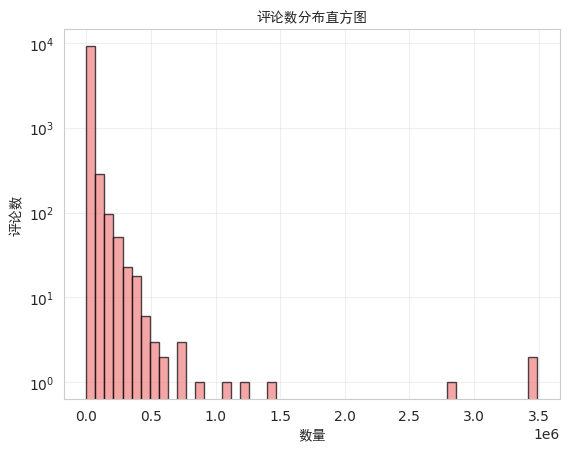

In [26]:
# 绘制直方图
plt.Figure(figsize=(12, 8))
bins = 50
n, bins, patches = plt.hist(comments_count, bins=bins, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('数量', fontproperties=font)
plt.ylabel('评论数', fontproperties=font)
plt.title('评论数分布直方图', fontproperties=font)
plt.yscale('log')
plt.grid(True, alpha=0.3)

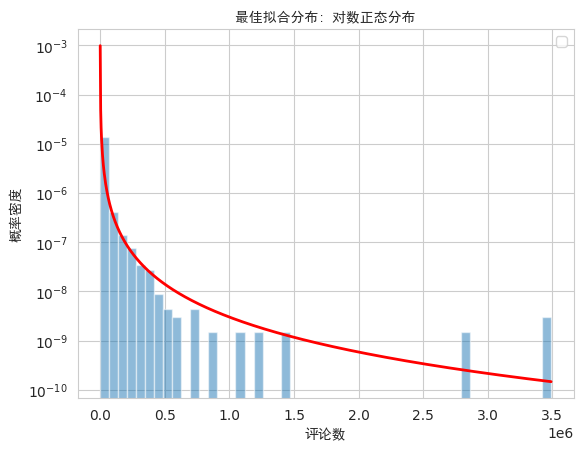

In [35]:
# 尝试拟合多种分布
plt.Figure(figsize=(10, 6))
distributions = [
    ('正态分布', stats.norm),
    ('对数正态分布', stats.lognorm),
    ('指数分布', stats.expon),
    ('伽马分布', stats.gamma),
    ('威布尔分布', stats.weibull_min),
    ('帕累托分布', stats.pareto)
]

best_dist = None
best_params = None
best_sse = np.inf
results = []

for dist_name, distribution in distributions:
    try:
        # 拟合分布参数
        params = distribution.fit(comments_count)
        
        # 计算拟合优度 (SSE)
        expected = distribution.pdf(bins[:-1], *params) * len(comments_count) * (bins[1] - bins[0])
        sse = np.sum((n - expected/len(comments_count))**2)
        
        results.append((dist_name, params, sse))
        
        if sse < best_sse:
            best_sse = sse
            best_dist = distribution
            best_params = params
            best_dist_name = dist_name
            
    except Exception as e:
        print(f"拟合 {dist_name} 时出错: {e}")

# 在直方图上绘制最佳拟合分布
x_fit = np.linspace(comments_count.min(), comments_count.max(), 1000)
y_fit = best_dist.pdf(x_fit, *best_params)
plt.plot(x_fit, y_fit, 'r-', linewidth=2)
plt.hist(comments_count, bins=bins, density=True, alpha=0.5)
plt.title(f'最佳拟合分布: {best_dist_name}', fontproperties=font)
plt.ylabel('概率密度', fontproperties=font)
plt.xlabel('评论数', fontproperties=font)
plt.legend(prop = font)
plt.yticks([1, 10, 100, 1000, 10000])
plt.yscale('log')
plt.legend()